Test


Running Test Case 1


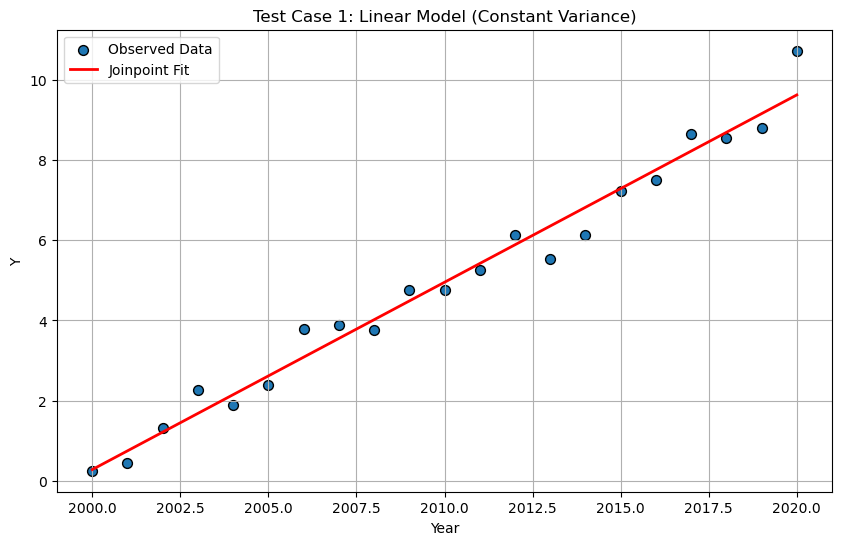


Running Test Case 2


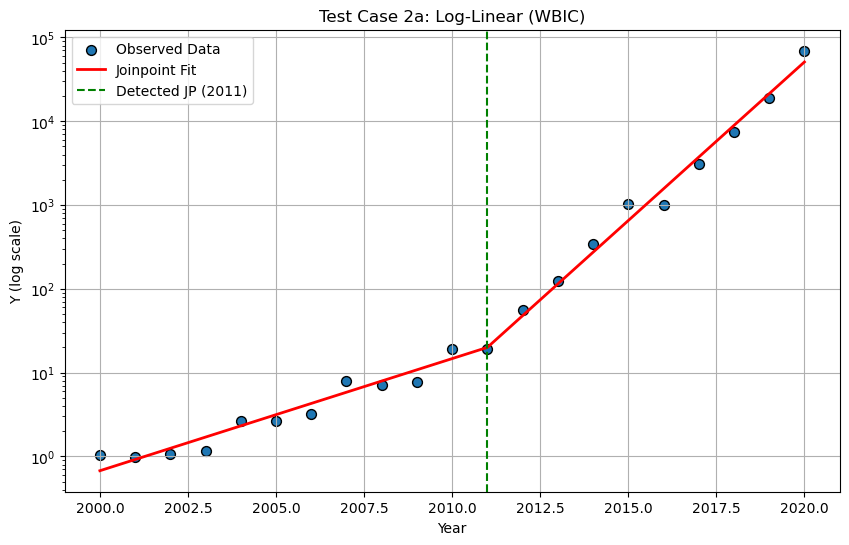


Running Test Case 3


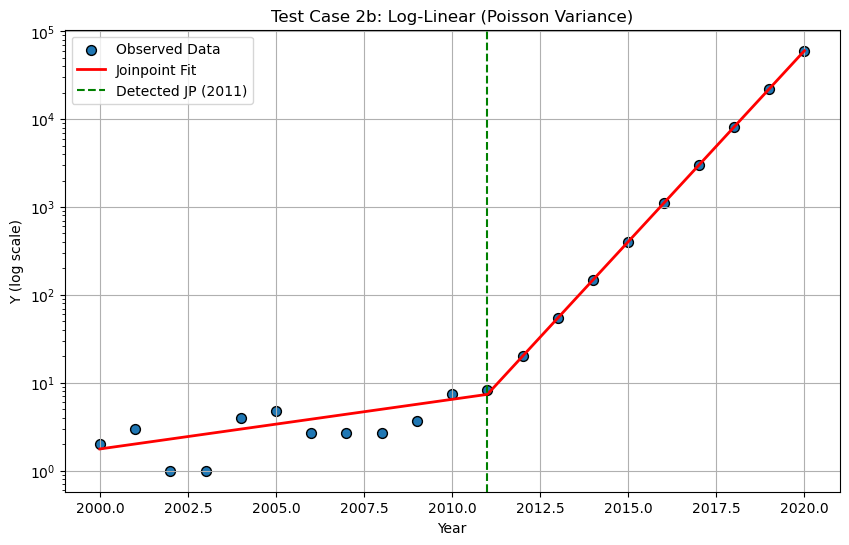


Running Test Case 4


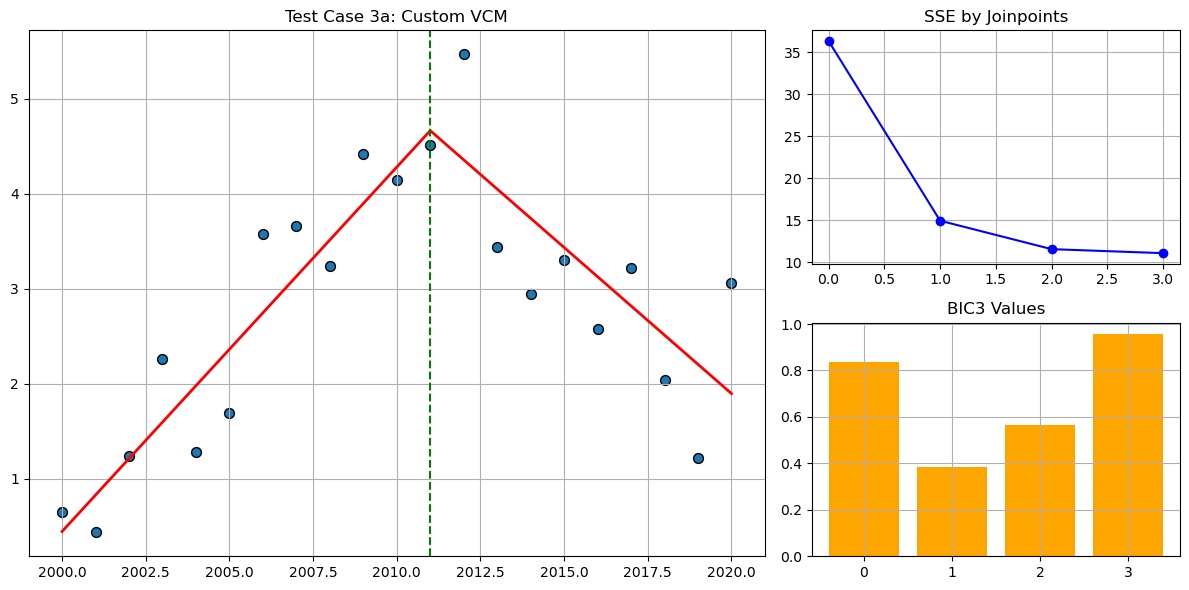


Running Test Case 5
Finding best model using all available 28 cores...

Info: Starting sequential permutation testing procedure.

--- Testing H0: k=0 vs H1: k=1 (Corrected alpha=0.0250) ---
--- Test complete in 1.15 seconds. ---
Result: p=0.0100 < 0.0250. Reject H0. The model has at least 1 joinpoints.

--- Testing H0: k=1 vs H1: k=2 (Corrected alpha=0.0500) ---
--- Test complete in 4.43 seconds. ---
Result: p=0.0100 < 0.0500. Reject H0. The model has at least 2 joinpoints.

Permutation testing concluded. Final selected number of joinpoints: k = 2


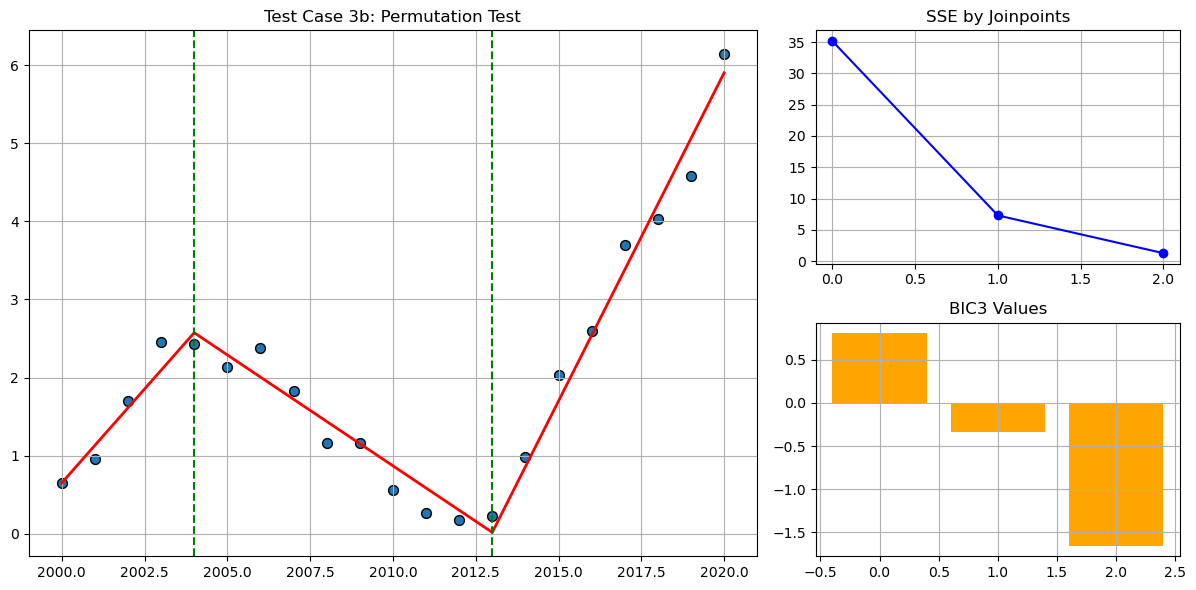


Running Test Case 6


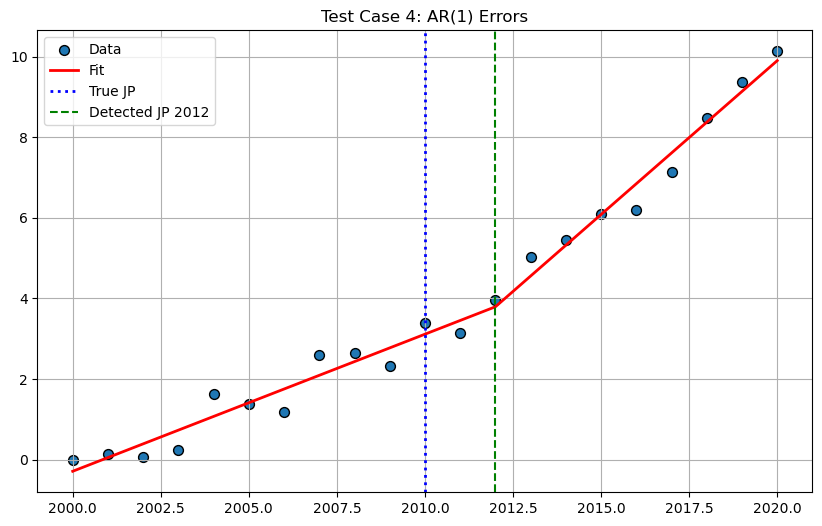


Running Test Case 7
Finding best model using 2 parallel jobs...


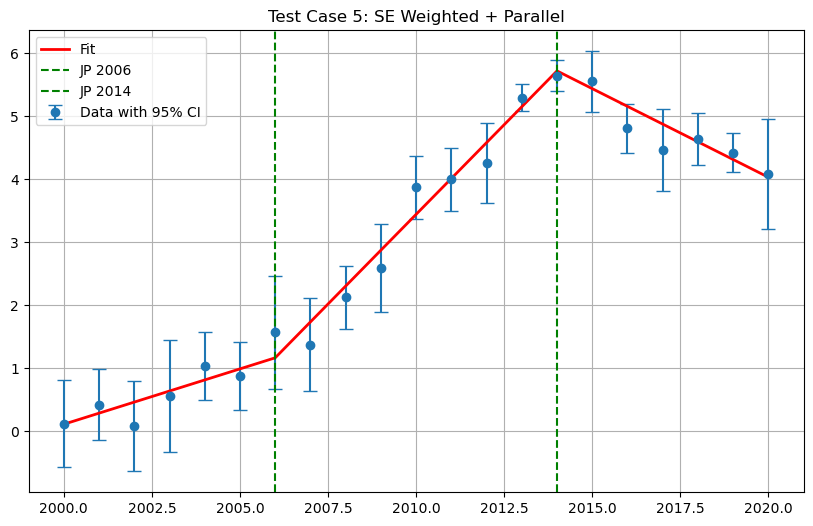

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from joinpoint_regression import joinpoint_regression  # Import the function
import warnings

def run_all_tests(savefig=True, show=True):
    """Executes all test cases and generates visualization results."""

    # Test Case 1: Simple linear model + constant variance + BIC selection
    def test_case1():
        try:
            np.random.seed(42)
            x = np.arange(2000, 2021)
            y = 0.5*(x-2000) + np.random.normal(0, 0.5, len(x))

            results = joinpoint_regression(
                x=x, y=y,
                max_joinpoints=3,
                heteroscedasticity_option='constant',
                model_selection_method='BIC'
            )

            plt.figure(figsize=(10,6))
            plt.scatter(x, y, s=50, edgecolor='k', label='Observed Data')
            plt.plot(x, results['fitted_values'], 'r-', lw=2, label='Joinpoint Fit')
            plt.title('Test Case 1: Linear Model (Constant Variance)')
            plt.xlabel('Year'), plt.ylabel('Y')
            plt.legend()
            plt.grid(True)
            if savefig: plt.savefig('test_case1.png')
            if show: plt.show()
            return results
        except Exception as e:
            print(f"Test Case 1 failed: {e}")
            return None

    # Test Case 2a: Log-linear model + WBIC
    def test_case2a():
        try:
            np.random.seed(42)
            x = np.arange(2000, 2021)
            true_jp = 2010
            slopes = [0.3, 0.8]
            y = np.piecewise(x, [x < true_jp],
                            [lambda x: slopes[0]*(x-2000),
                             lambda x: slopes[0]*(true_jp-2000) + slopes[1]*(x-true_jp)])
            y = np.exp(y + np.random.normal(0, 0.1, len(x)))  # Exponential noise

            results = joinpoint_regression(
                x=x, y=y,
                type='log-linear',
                max_joinpoints=3,
                heteroscedasticity_option='constant',  # Changed from 'pv' to 'constant'
                model_selection_method='WBIC'
            )

            plt.figure(figsize=(10,6))
            plt.scatter(x, y, s=50, edgecolor='k', label='Observed Data')
            plt.plot(x, np.exp(results['fitted_values']), 'r-', lw=2, label='Joinpoint Fit')
            for jp in results['best_joinpoints']:
                plt.axvline(jp, color='g', linestyle='--', lw=1.5,
                           label=f'Detected JP ({jp})')
            plt.title('Test Case 2a: Log-Linear (WBIC)')
            plt.xlabel('Year'), plt.ylabel('Y (log scale)')
            plt.yscale('log')
            plt.legend()
            plt.grid(True)
            if savefig: plt.savefig('test_case2a.png')
            if show: plt.show()
            return results
        except Exception as e:
            print(f"Test Case 2a failed: {e}")
            return None

    # Test Case 2b: Log-linear model + Poisson variance
    def test_case2b():
        try:
            np.random.seed(42)
            x = np.arange(2000, 2021)
            true_jp = 2010
            slopes = [0.2, 0.9]
            y = np.piecewise(x, [x < true_jp],
                            [lambda x: slopes[0]*(x-2000),
                             lambda x: slopes[0]*(true_jp-2000) + slopes[1]*(x-true_jp)])
            y = np.exp(y)+ np.random.poisson(lam=1,size=len(x))  # poisson noise

            results = joinpoint_regression(
                x=x, y=y,
                type='log-linear',
                max_joinpoints=3,min_points_between_jp=3,
                heteroscedasticity_option='pv',  # Poisson variance
                model_selection_method='BIC3'  # Changed from WBIC to BIC
            )

            plt.figure(figsize=(10,6))
            plt.scatter(x, y, s=50, edgecolor='k', label='Observed Data')
            plt.plot(x, np.exp(results['fitted_values']), 'r-', lw=2, label='Joinpoint Fit')
            for jp in results['best_joinpoints']:
                plt.axvline(jp, color='g', linestyle='--', lw=1.5,
                           label=f'Detected JP ({jp})')
            plt.title('Test Case 2b: Log-Linear (Poisson Variance)')
            plt.xlabel('Year'), plt.ylabel('Y (log scale)')
            plt.yscale('log')
            plt.legend()
            plt.grid(True)
            if savefig: plt.savefig('test_case2b.png')
            if show: plt.show()
            return results
        except Exception as e:
            print(f"Test Case 2b failed: {e}")
            return None

    # Test Case 3a: Custom VCM
    def test_case3a():
        try:
            np.random.seed(42)
            x = np.arange(2000, 2021)
            true_jps = [2005, 2013]
            slopes = [0.2, 0.5, -0.3]
            seq = []
            current = 0
            for xi in x:
                if xi < true_jps[0]: current += slopes[0]
                elif xi < true_jps[1]: current += slopes[1]
                else: current += slopes[2]
                seq.append(current)
            y = np.array(seq)

            # Create a variance-covariance matrix with correlation
            n = len(x)
            vcm = np.eye(n)*0.5
            for i in range(n):
                for j in range(n):
                    vcm[i,j] += 0.3*(0.9**abs(i-j))

            # Generate noise consistent with VCM
            L = np.linalg.cholesky(vcm)  # Cholesky decomposition
            noise = np.dot(L, np.random.normal(0, 1, n))
            y = y + noise

            results = joinpoint_regression(
                x=x, y=y,
                max_joinpoints=3,
                heteroscedasticity_option='vcm',
                vcm=vcm,
                model_selection_method='BIC'  # Changed from permutation to BIC
            )

            fig = plt.figure(figsize=(12,6))
            gs = GridSpec(2, 2, width_ratios=[2,1])

            ax1 = fig.add_subplot(gs[:,0])
            ax1.scatter(x, y, s=50, edgecolor='k', label='Data')
            ax1.plot(x, results['fitted_values'], 'r-', lw=2, label='Fit')
            for jp in results['best_joinpoints']:
                ax1.axvline(jp, color='g', ls='--', label=f'JP {jp}')
            ax1.set_title('Test Case 3a: Custom VCM')
            ax1.grid(True)

            ax2 = fig.add_subplot(gs[0,1])
            model_summary = results['model_summary_df']
            ax2.plot(model_summary['k'], model_summary['sse'], 'bo-')
            ax2.set_title('SSE by Joinpoints'), ax2.grid(True)

            ax3 = fig.add_subplot(gs[1,1])
            ax3.bar(model_summary['k'], model_summary['bic3'], color='orange')
            ax3.set_title('BIC3 Values'), ax3.grid(True)

            plt.tight_layout()
            if savefig: plt.savefig('test_case3a.png')
            if show: plt.show()
            return results
        except Exception as e:
            print(f"Test Case 3a failed: {e}")
            return None

    # Test Case 3b: Permutation test
    def test_case3b():
        try:
            np.random.seed(42)
            x = np.arange(2000, 2021)
            true_jps = [2005, 2013]
            slopes = [0.5, -0.3, 0.7]
            seq = []
            current = 0
            for xi in x:
                if xi < true_jps[0]: current += slopes[0]
                elif xi < true_jps[1]: current += slopes[1]
                else: current += slopes[2]
                seq.append(current)
            y = np.array(seq) + np.random.normal(0, 0.3, len(x))

            results = joinpoint_regression(
                x=x, y=y,
                max_joinpoints=2,
                heteroscedasticity_option='constant',
                model_selection_method='permutation',
                num_permutations=99,  # Reduced permutations for demonstration
                parallel=True,
                n_jobs=-1
            )

            fig = plt.figure(figsize=(12,6))
            gs = GridSpec(2, 2, width_ratios=[2,1])

            ax1 = fig.add_subplot(gs[:,0])
            ax1.scatter(x, y, s=50, edgecolor='k', label='Data')
            ax1.plot(x, results['fitted_values'], 'r-', lw=2, label='Fit')
            for jp in results['best_joinpoints']:
                ax1.axvline(jp, color='g', ls='--', label=f'JP {jp}')
            ax1.set_title('Test Case 3b: Permutation Test')
            ax1.grid(True)

            ax2 = fig.add_subplot(gs[0,1])
            model_summary = results['model_summary_df']
            ax2.plot(model_summary['k'], model_summary['sse'], 'bo-')
            ax2.set_title('SSE by Joinpoints'), ax2.grid(True)

            ax3 = fig.add_subplot(gs[1,1])
            ax3.bar(model_summary['k'], model_summary['bic3'], color='orange')
            ax3.set_title('BIC3 Values'), ax3.grid(True)

            plt.tight_layout()
            if savefig: plt.savefig('test_case3b.png')
            if show: plt.show()
            return results
        except Exception as e:
            print(f"Test Case 3b failed: {e}")
            return None

    # Test Case 4: AR1 errors + BIC3
    def test_case4():
        try:
            np.random.seed(42)
            x = np.arange(2000, 2021)
            phi = 0.7  # AR(1) coefficient
            true_jp = 2010
            slopes = [0.3, 0.8]

            # Generate AR(1) errors
            errors = np.zeros(len(x))
            for t in range(1, len(x)):
                errors[t] = phi*errors[t-1] + np.random.normal(0, 0.3)

            y = np.piecewise(x, [x < true_jp],
                            [lambda x: slopes[0]*(x-2000),
                             lambda x: slopes[0]*(true_jp-2000) + slopes[1]*(x-true_jp)]) + errors

            results = joinpoint_regression(
                x=x, y=y,
                max_joinpoints=3,
                heteroscedasticity_option='ar1',
                rho=0.7,
                model_selection_method='BIC3',
                ar_maxiter=5
            )

            plt.figure(figsize=(10,6))
            plt.scatter(x, y, s=50, edgecolor='k', label='Data')
            plt.plot(x, results['fitted_values'], 'r-', lw=2, label='Fit')
            plt.axvline(true_jp, color='b', ls=':', lw=2, label='True JP')
            for jp in results['best_joinpoints']:
                plt.axvline(jp, color='g', ls='--', label=f'Detected JP {jp}')
            plt.title('Test Case 4: AR(1) Errors')
            plt.legend()
            plt.grid(True)
            if savefig: plt.savefig('test_case4.png')
            if show: plt.show()
            return results
        except Exception as e:
            print(f"Test Case 4 failed: {e}")
            return None

    # Test Case 5: Standard error weighting + parallel computation
    def test_case5():
        try:
            np.random.seed(42)
            x = np.arange(2000, 2021)
            true_jps = [2008, 2015]
            slopes = [0.2, 0.6, -0.3]
            y = []
            current = 0
            for xi in x:
                if xi < true_jps[0]: current += slopes[0]
                elif xi < true_jps[1]: current += slopes[1]
                else: current += slopes[2]
                y.append(current)
            y = np.array(y)

            # Generate standard errors
            se = np.abs(np.random.normal(0.3, 0.1, len(x)))
            # Generate noise consistent with SE
            noise = np.random.normal(0, se, len(x))
            y = y + noise

            results = joinpoint_regression(
                x=x, y=y,
                max_joinpoints=3,
                heteroscedasticity_option='se',
                se=se,
                model_selection_method='BIC',
                parallel=True,
                n_jobs=2
            )

            plt.figure(figsize=(10,6))
            plt.errorbar(x, y, yerr=1.96*se, fmt='o', capsize=5,
                        label='Data with 95% CI')
            plt.plot(x, results['fitted_values'], 'r-', lw=2, label='Fit')
            for jp in results['best_joinpoints']:
                plt.axvline(jp, color='g', ls='--', label=f'JP {jp}')
            plt.title('Test Case 5: SE Weighted + Parallel')
            plt.legend()
            plt.grid(True)
            if savefig: plt.savefig('test_case5.png')
            if show: plt.show()
            return results
        except Exception as e:
            print(f"Test Case 5 failed: {e}")
            return None

    # Execute all test cases
    tests = [test_case1, test_case2a, test_case2b, test_case3a, test_case3b, test_case4, test_case5]
    results = []
    for i, test in enumerate(tests):
        print(f"\n{'='*50}\nRunning Test Case {i+1}\n{'='*50}")
        results.append(test())

    return results

if __name__ == "__main__":

    results = run_all_tests(savefig=True, show=True)